<a href="https://www.kaggle.com/code/maziprimareza/ecommerce-sales-forecast-using-prophet?scriptVersionId=135481084" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brazilian-ecommerce/olist_customers_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_sellers_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_reviews_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_geolocation_dataset.csv
/kaggle/input/brazilian-ecommerce/product_category_name_translation.csv
/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_payments_dataset.csv


In [2]:
!pip install holidays

In [3]:
!pip install prophet

In [4]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
import itertools
import holidays
from sklearn.preprocessing import MinMaxScaler
from prophet import Prophet
from IPython.display import clear_output
from tqdm import tqdm
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

In [5]:
orders = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv')
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


# Exploratory Data Analysis
Let's take a look at the data first!

### About Order Dataset
there's no further explanation on order status, but let's just define it something like...<br>
> success: shipped, delivered, invoiced <br>
> failed: canceled, unavailable <br>
> payment in progress: processing, approved, created

In [6]:
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders = orders[(orders['order_purchase_timestamp']>=pd.to_datetime('2017-01-01')) & (orders['order_purchase_timestamp']<=pd.to_datetime('2018-08-20'))]
orders = orders[['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp']]
orders = orders[orders['order_status'].isin(['shipped','delivered','invoiced'])]
orders['date'] = orders['order_purchase_timestamp'].dt.date

In [7]:
orders = orders.groupby('date').agg(total_orders=('order_id', 'nunique')).reset_index()

In [8]:
orders['date'] = pd.to_datetime(orders['date'])
orders['dayofweek'] = orders['date'].dt.dayofweek
orders['quarter'] = orders['date'].dt.quarter
orders['month'] = orders['date'].dt.month
orders['year'] = orders['date'].dt.year
orders['dayofyear'] = orders['date'].dt.dayofyear
orders['dayofmonth'] = orders['date'].dt.day
orders['weekofyear'] = orders['date'].dt.weekofyear

/tmp/ipykernel_20/2606553907.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  orders['weekofyear'] = orders['date'].dt.weekofyear


In [9]:
# add holidays information to the data
br_holidays = holidays.BR()
orders['events'] = orders['date'].apply(lambda x: br_holidays.get(x))

In [10]:
orders.loc[orders['date']==pd.to_datetime('2017-11-24'), 'events'] = 'black friday'

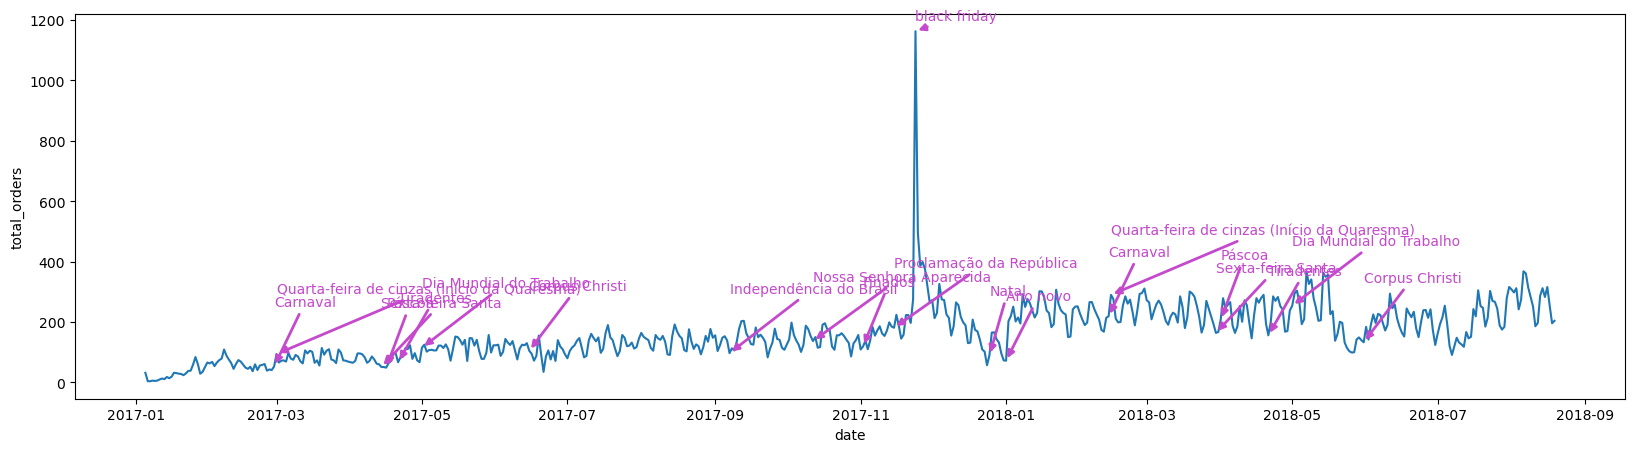

In [11]:
ann_color = '#c449cc' # annotation color
arrowprops=dict(arrowstyle='-|>', color=ann_color, linewidth=2)
plt.figure(figsize=(20,5))
sns.lineplot(data=orders, x='date', y='total_orders')

events = orders[orders['events'].notna()].to_dict('records')
for event in events:
    plt.annotate(event['events'], 
                xy=(event['date'], event['total_orders']), # arrow position (x, y)
                xytext=(event['date'], min(event['total_orders'] + 200, 1200)), # text position (x, y)
                fontsize=10,
                arrowprops=arrowprops,
                color=ann_color)

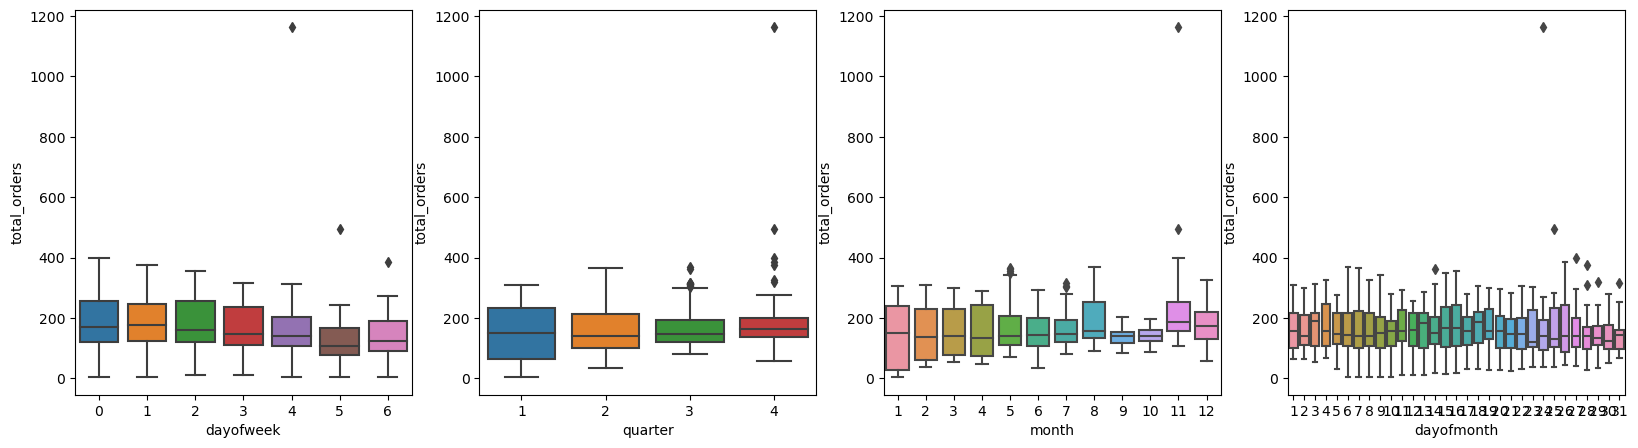

In [12]:
# There is a pattern in weekly sales, people tend to buy product on weekday instead of weekend, buy more in the middle and end of year, and buy less in the end of month

fig, ax = plt.subplots(1,4,figsize=(20,5))
for idx, col in enumerate(['dayofweek', 'quarter', 'month', 'dayofmonth']):
    sns.boxplot(data=orders, x=col, y='total_orders', ax=ax[idx])

# Data Preprocessing
1. Min-Max Scaler
2. Remove Outliers

In [13]:
dates = orders['date'].sort_values().unique()
num_dates = len(dates)
dates_train = dates[:int(0.8*num_dates)]
dates_test = dates[int(0.8*num_dates):]
train = orders[orders['date'].isin(dates_train)]
test = orders[orders['date'].isin(dates_test)]

In [14]:
scaler = MinMaxScaler()
scaler.fit(train[['total_orders']])
train['scaling'] = scaler.transform(train[['total_orders']])
test['scaling'] = scaler.transform(test[['total_orders']])

/tmp/ipykernel_20/2471818048.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['scaling'] = scaler.transform(train[['total_orders']])
/tmp/ipykernel_20/2471818048.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['scaling'] = scaler.transform(test[['total_orders']])


In [15]:
train['rmv_outliers'] = winsorize(train['scaling'], (0.01,0.009))

/tmp/ipykernel_20/602262428.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['rmv_outliers'] = winsorize(train['scaling'], (0.01,0.009))


In [16]:
winsorized_min, winsorized_max = train[train['rmv_outliers']!=train['scaling']]['rmv_outliers'].min(), train[train['rmv_outliers']!=train['scaling']]['rmv_outliers'].max()
winsorized_min, winsorized_max

(0.0017256255392579813, 0.3201035375323555)

In [17]:
test.loc[test['scaling']>winsorized_max, 'rmv_outliers'] = winsorized_max
test.loc[test['scaling']<winsorized_min, 'rmv_outliers'] = winsorized_min
test.loc[(test['scaling']>=winsorized_min)&(test['scaling']<=winsorized_max), 'rmv_outliers'] = test[(test['scaling']>=winsorized_min)&(test['scaling']<=winsorized_max)]['scaling']

/tmp/ipykernel_20/1080229728.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[test['scaling']>winsorized_max, 'rmv_outliers'] = winsorized_max
/tmp/ipykernel_20/1080229728.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[(test['scaling']>=winsorized_min)&(test['scaling']<=winsorized_max), 'rmv_outliers'] = test[(test['scaling']>=winsorized_min)&(test['scaling']<=winsorized_max)]['scaling']


In [18]:
def plot_evaluation(dataset):
    fig, ax = plt.subplots(1,4,figsize=(20,5))
    for idx, col in enumerate(['dayofweek', 'quarter', 'month', 'dayofmonth']):
        plot_data = dataset.groupby(col)['squared_error'].mean().apply(np.sqrt).reset_index()
        sns.barplot(data=plot_data, x=col, y='squared_error', ax=ax[idx], color='orange')
        ax[idx].set_ylabel('RMSE')

    fig, ax = plt.subplots(1,2,figsize=(20,3))
    plot_data = dataset.groupby(['y','yhat'])['squared_error'].mean().apply(np.sqrt).reset_index()
    sns.scatterplot(data=plot_data, x='y', y='yhat', ax=ax[0], color='black')
    sns.scatterplot(data=plot_data, x='y', y='squared_error', ax=ax[1], color='black')
    ax[0].set_title("Correlation between actual and predicted sales")
    ax[0].set_xlabel('Actual Value')
    ax[0].set_ylabel('Predicted Value')
    ax[1].set_xlabel('Actual Value')
    ax[1].set_ylabel('RMSE')
    ax[1].set_title("Correlation between actual and RMSE")
    plt.show()

In [19]:
param_grid = {  
#     'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'changepoint_prior_scale': [0.001],
#     'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_prior_scale': [1],
    'seasonality_mode': ['additive', 'multiplicative']
}

def predict_eval(train, test, variant, tuning=False):
    dataset = train.copy()
    dataset_test = test.copy()
    col = {'date':'ds', variant:'y'}
    dataset = dataset.rename(columns=col)
    dataset_test = dataset_test.rename(columns=col)
    m = Prophet()
    
    if tuning:
        # Generate all combinations of parameters
        all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
        rmses = []  # Store the RMSEs for each params here

        # Use cross validation to evaluate all parameters
        print("cross_validation")
        for params in tqdm(all_params):
            m = Prophet(**params).fit(dataset)  # Fit model with given params
            df_cv = cross_validation(model=m, initial='200 days', period='30 days', horizon = '30 days', parallel="processes")
            df_p = performance_metrics(df_cv, rolling_window=1)
            rmses.append(df_p['rmse'].values[0])
        clear_output()
        best_params = all_params[np.argmin(rmses)]
        print(best_params)
        m = Prophet(changepoint_prior_scale=best_params['changepoint_prior_scale'], seasonality_prior_scale=best_params['seasonality_prior_scale'], seasonality_mode=best_params['seasonality_mode'])

    m.fit(dataset)
    future = pd.DataFrame(dates_test, columns=['ds'])
    forecast = m.predict(future)
    forecast_today = m.predict(dataset)
    
    if variant in ['scaling', 'rmv_outliers']:
        forecast[['trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper', 
              'additive_terms', 'additive_terms_lower', 'additive_terms_upper','weekly', 
              'weekly_lower', 'weekly_upper', 'multiplicative_terms_upper', 'yhat']] = scaler.inverse_transform(
            forecast[['trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper', 'additive_terms', 
                      'additive_terms_lower', 'additive_terms_upper','weekly', 'weekly_lower', 
                      'weekly_upper', 'multiplicative_terms_upper', 'yhat']])

        forecast_today[['trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper', 
              'additive_terms', 'additive_terms_lower', 'additive_terms_upper','weekly', 
              'weekly_lower', 'weekly_upper', 'multiplicative_terms_upper', 'yhat']] = scaler.inverse_transform(
            forecast_today[['trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper', 'additive_terms', 
                            'additive_terms_lower', 'additive_terms_upper','weekly', 'weekly_lower', 
                            'weekly_upper', 'multiplicative_terms_upper', 'yhat']])
        dataset['y'] = scaler.inverse_transform(dataset[['y']])
        dataset_test['y'] = scaler.inverse_transform(dataset_test[['y']])

    forecast_today.index = dataset.index
    dataset['yhat'] = forecast_today['yhat']
    dataset['squared_error'] = np.square(dataset['y'] - dataset['yhat'])

    print("Train dataset evaluation")
    print(f"RMSE: {np.sqrt(dataset['squared_error'].mean())}")
    plot_evaluation(dataset)

    forecast.index = dataset_test.index
    dataset_test['yhat'] = forecast['yhat']
    dataset_test['squared_error'] = np.square(dataset_test['y'] - dataset_test['yhat'])

    print("Test dataset evaluation")
    print(f"RMSE: {np.sqrt(dataset_test['squared_error'].mean())}")
    plot_evaluation(dataset_test)

07:16:19 - cmdstanpy - INFO - Chain [1] start processing
07:16:20 - cmdstanpy - INFO - Chain [1] done processing


Train dataset evaluation
RMSE: 58.987353035667226


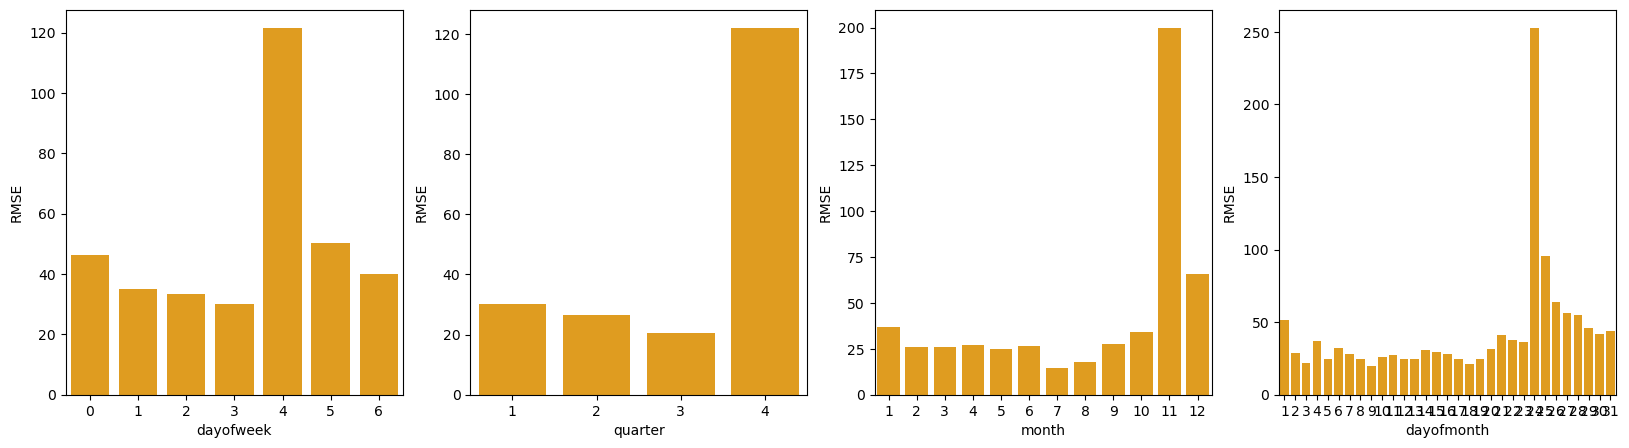

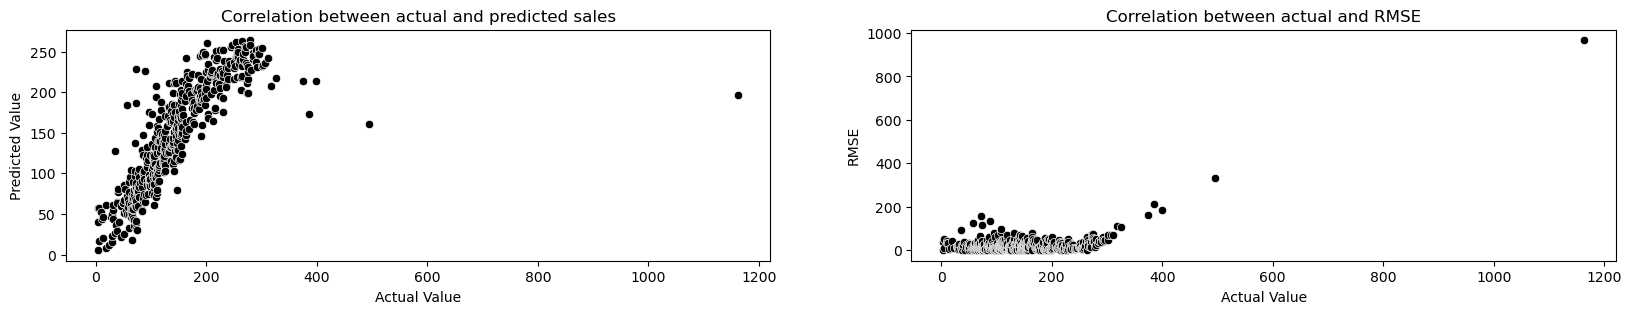

Test dataset evaluation
RMSE: 75.13812841041663


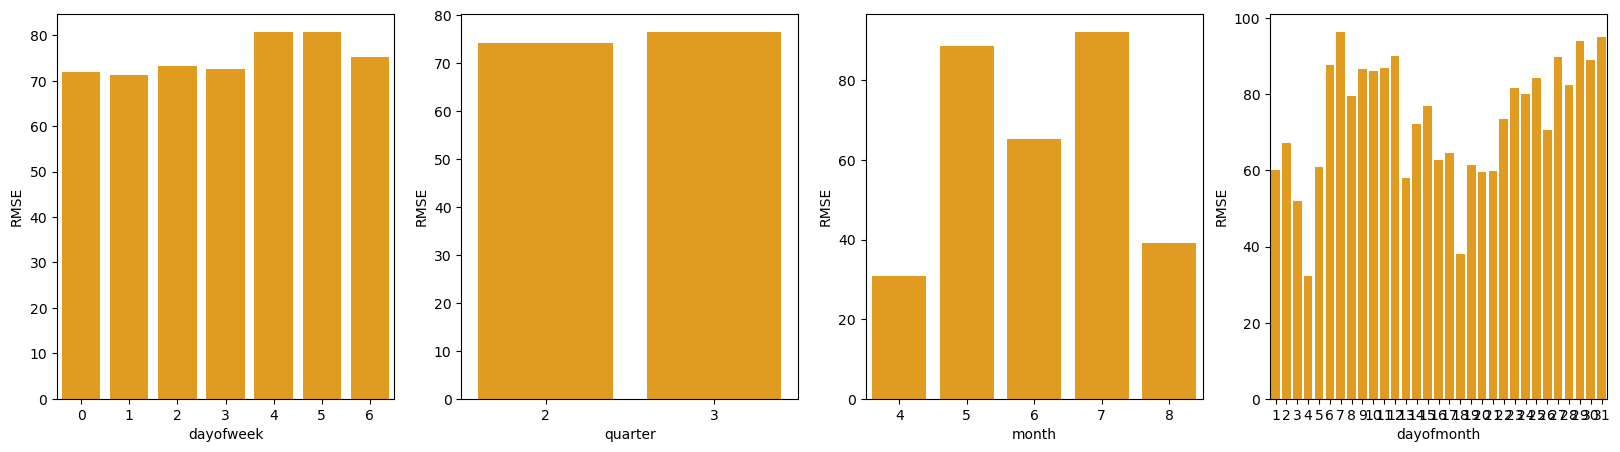

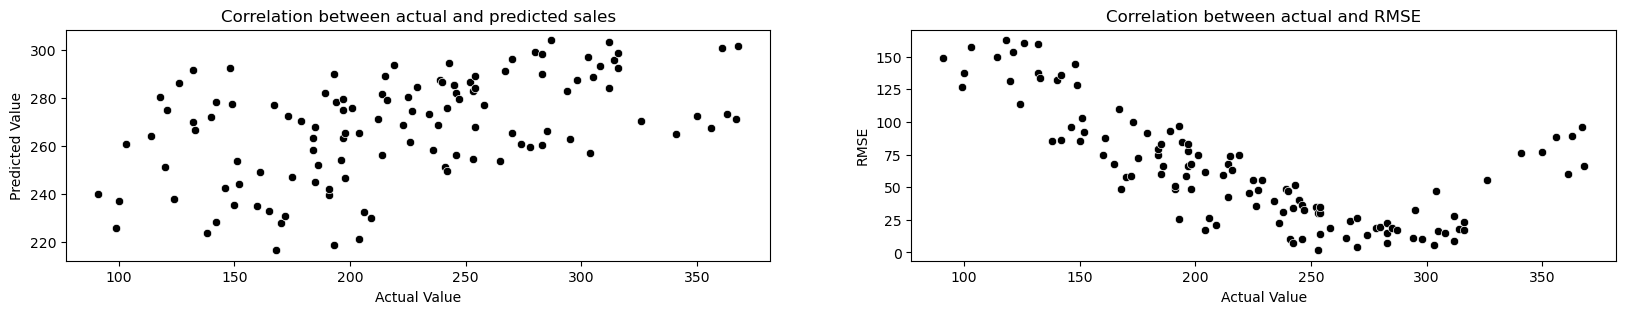

In [20]:
predict_eval(train, test, 'total_orders')

07:16:24 - cmdstanpy - INFO - Chain [1] start processing
07:16:24 - cmdstanpy - INFO - Chain [1] done processing


Train dataset evaluation
RMSE: 58.991214298881836


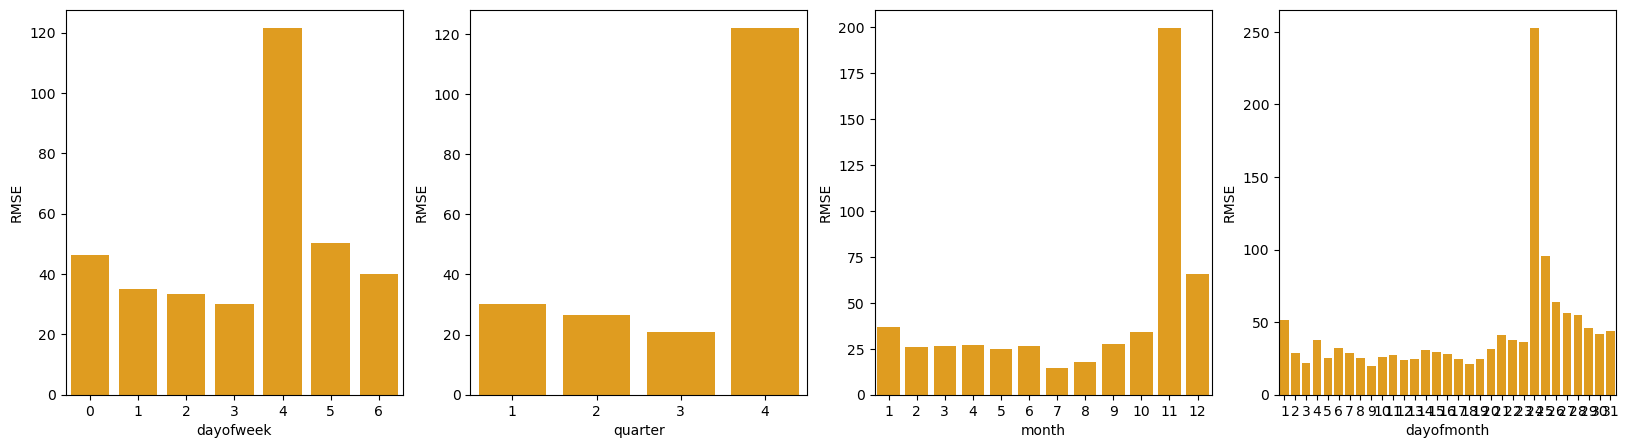

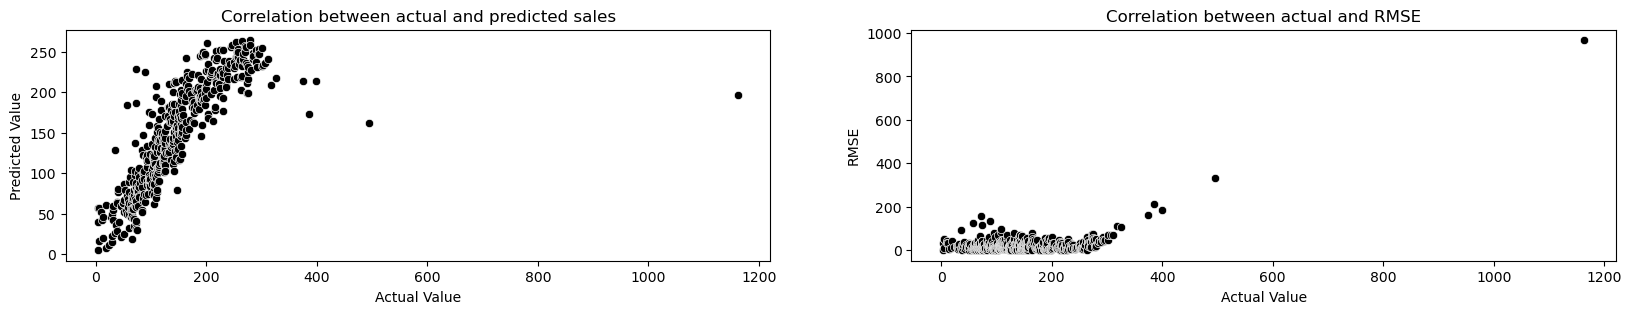

Test dataset evaluation
RMSE: 75.40876749118827


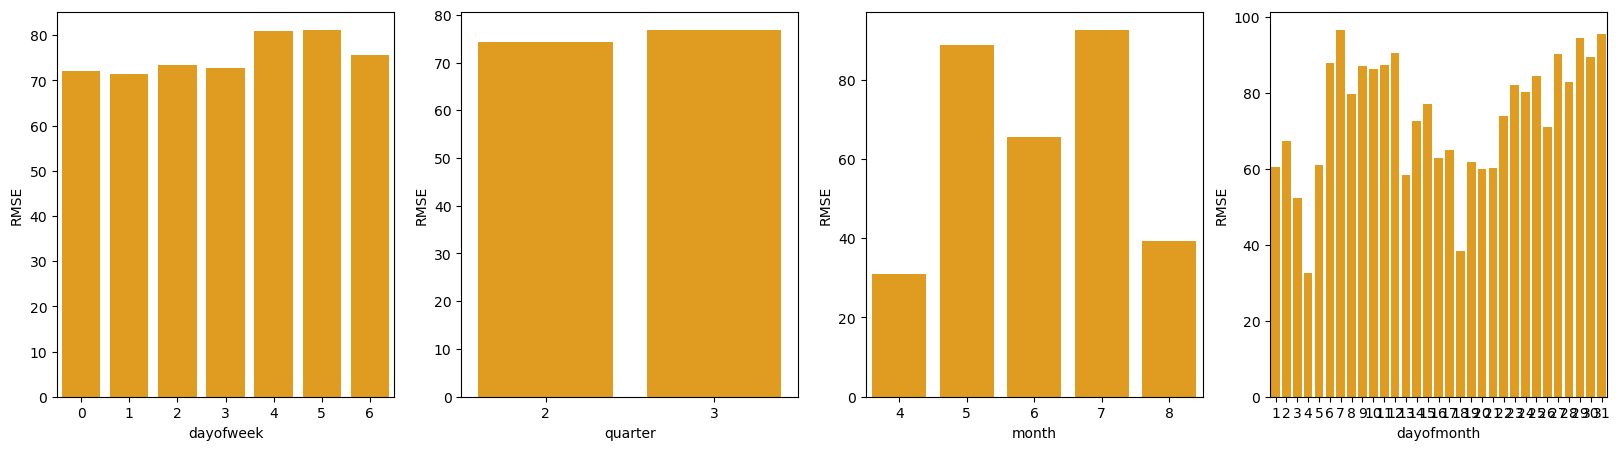

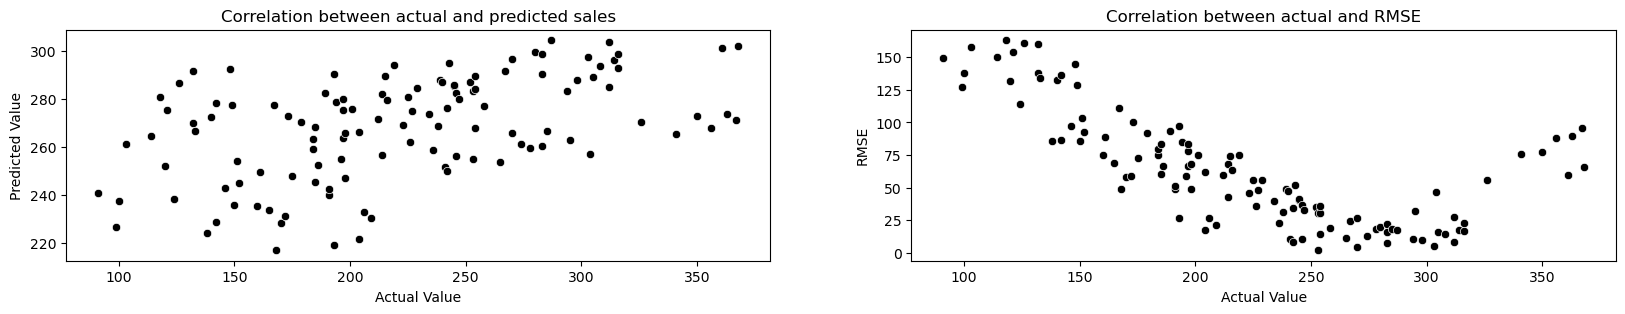

In [21]:
predict_eval(train, test, 'scaling')

07:16:28 - cmdstanpy - INFO - Chain [1] start processing
07:16:28 - cmdstanpy - INFO - Chain [1] done processing


Train dataset evaluation
RMSE: 37.442569851810525


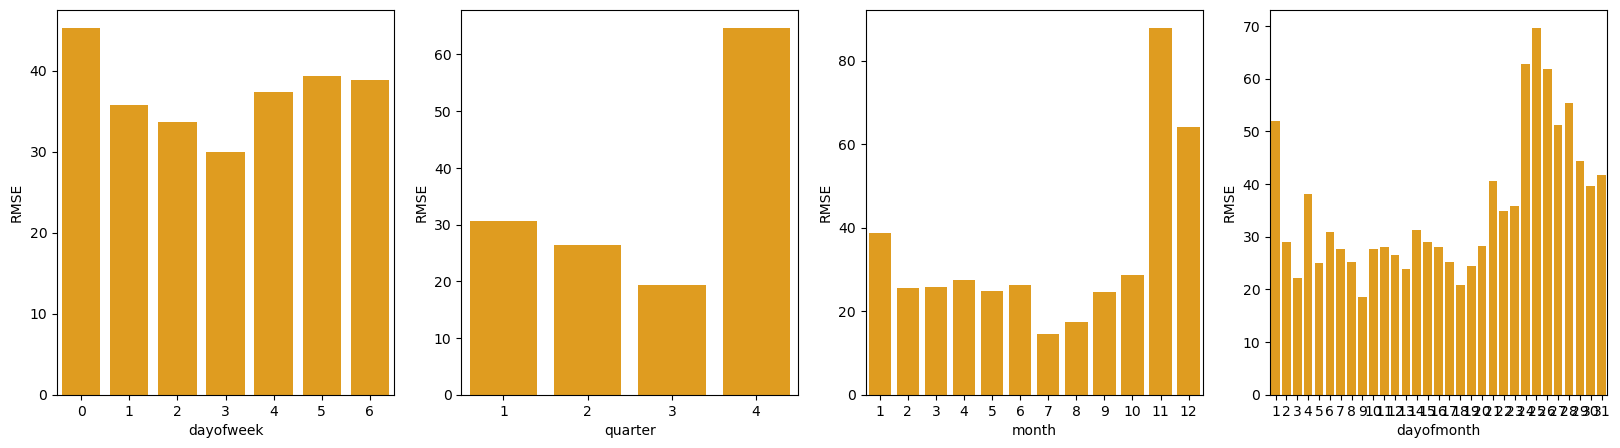

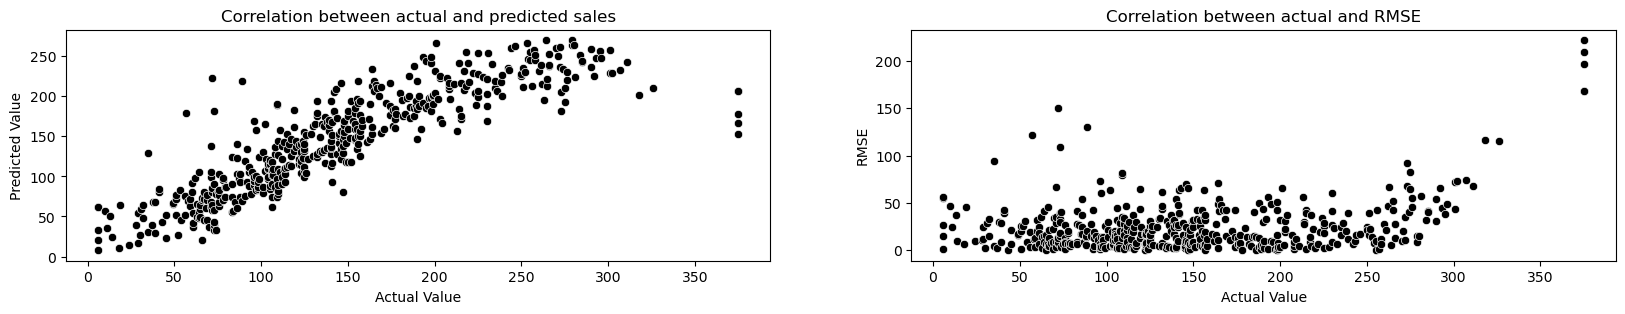

Test dataset evaluation
RMSE: 82.92169524670275


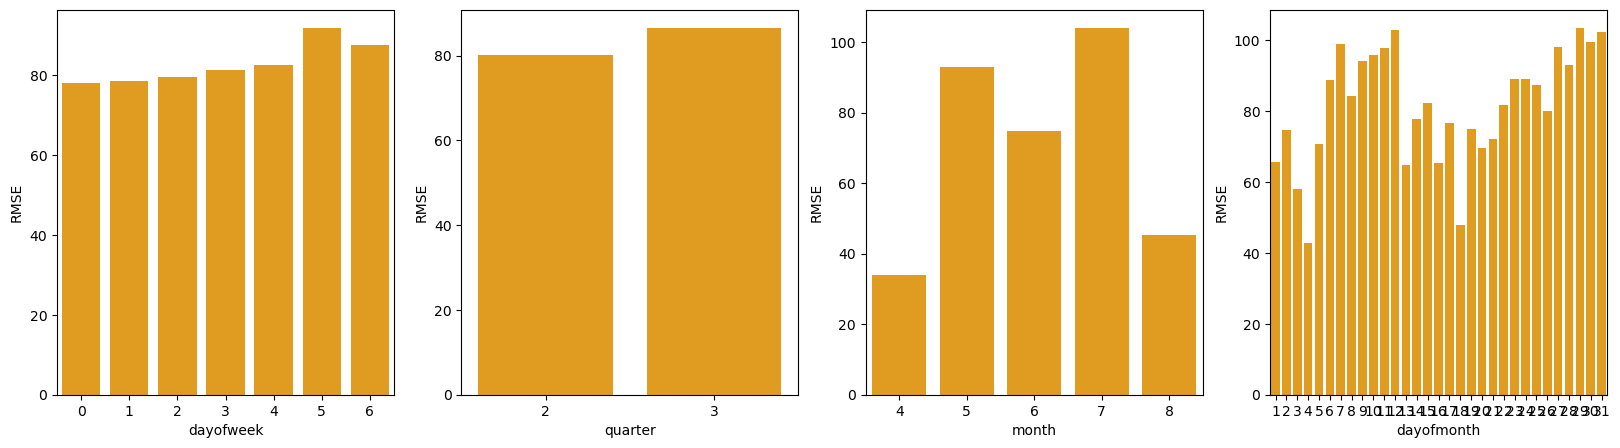

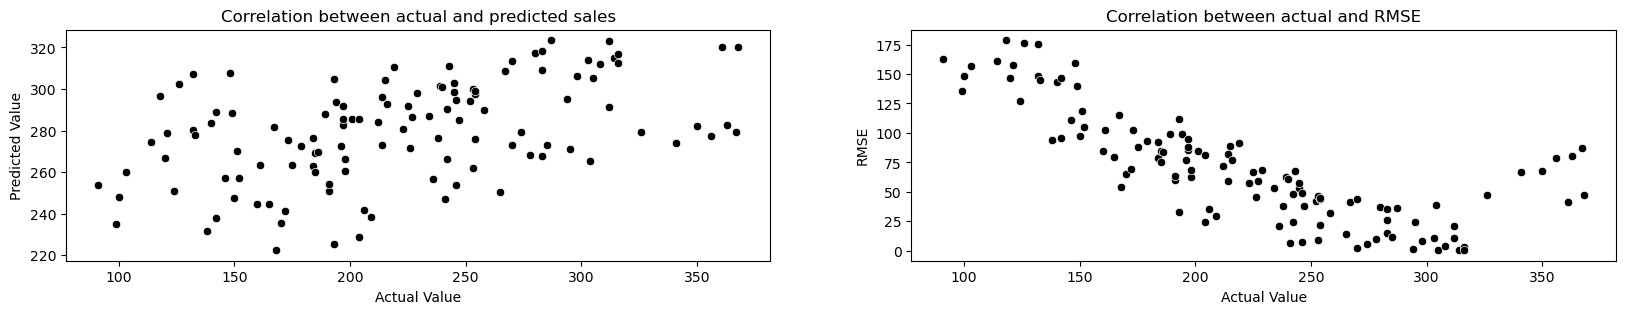

In [22]:
predict_eval(train, test, 'rmv_outliers')

# Hyperparamter Tuning

07:16:40 - cmdstanpy - INFO - Chain [1] start processing
07:16:40 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1, 'seasonality_mode': 'additive'}
Train dataset evaluation
RMSE: 59.97717627426213


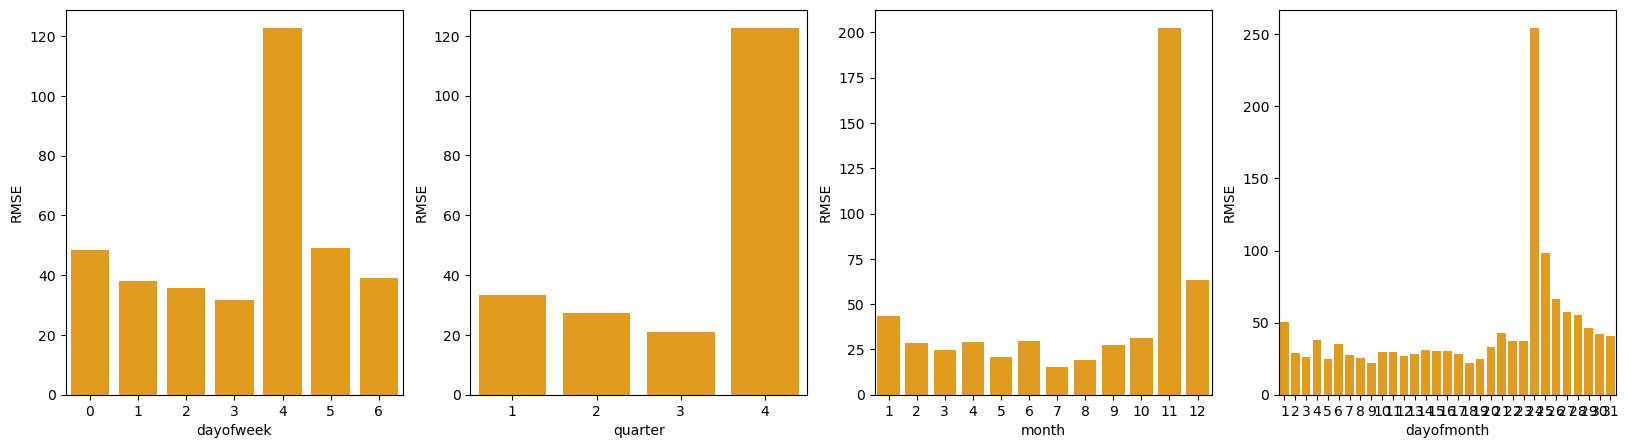

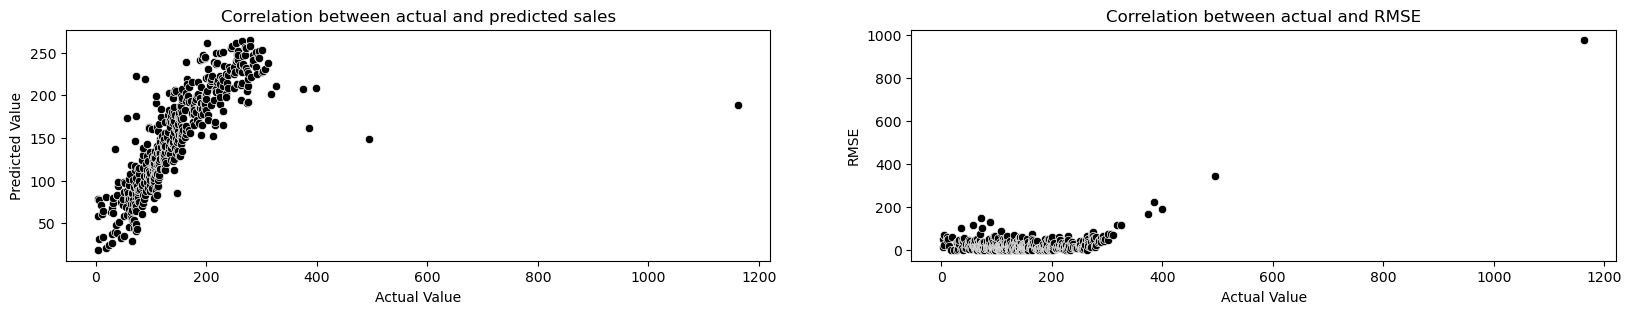

Test dataset evaluation
RMSE: 76.20309795002971


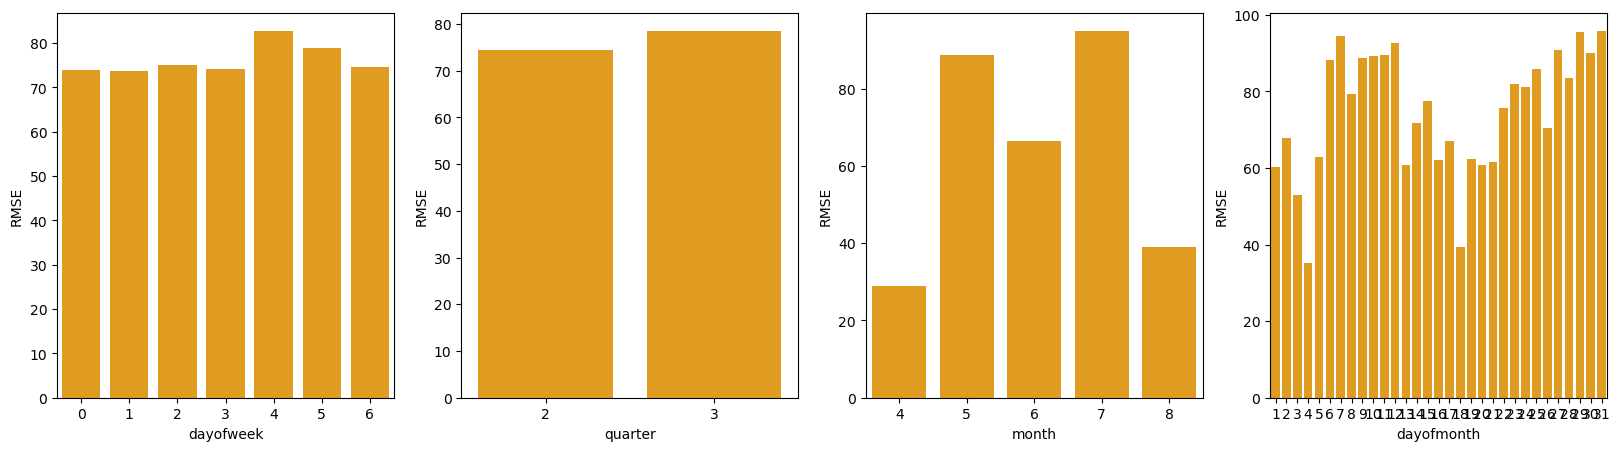

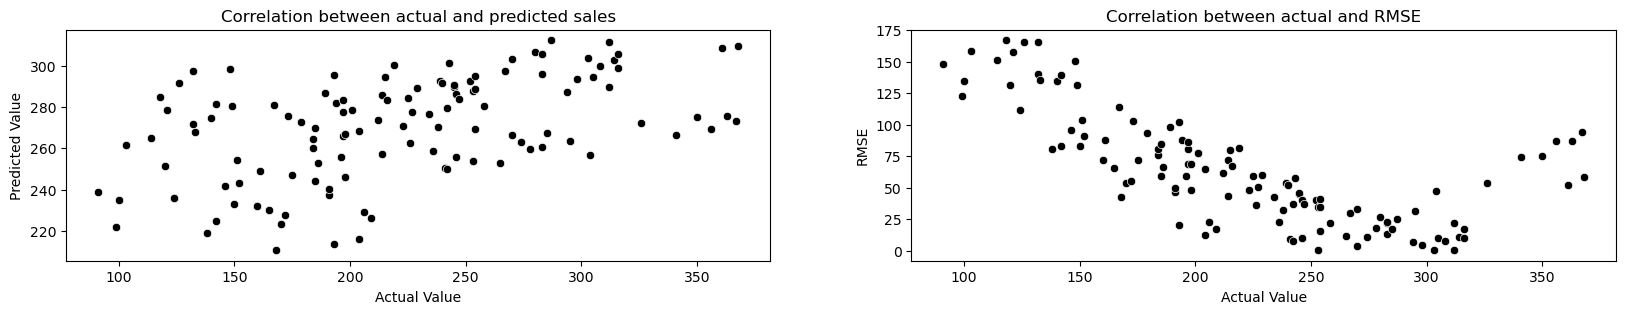

In [23]:
predict_eval(train, test, 'total_orders', tuning=True)

07:16:52 - cmdstanpy - INFO - Chain [1] start processing
07:16:52 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1, 'seasonality_mode': 'additive'}
Train dataset evaluation
RMSE: 59.88762446260267


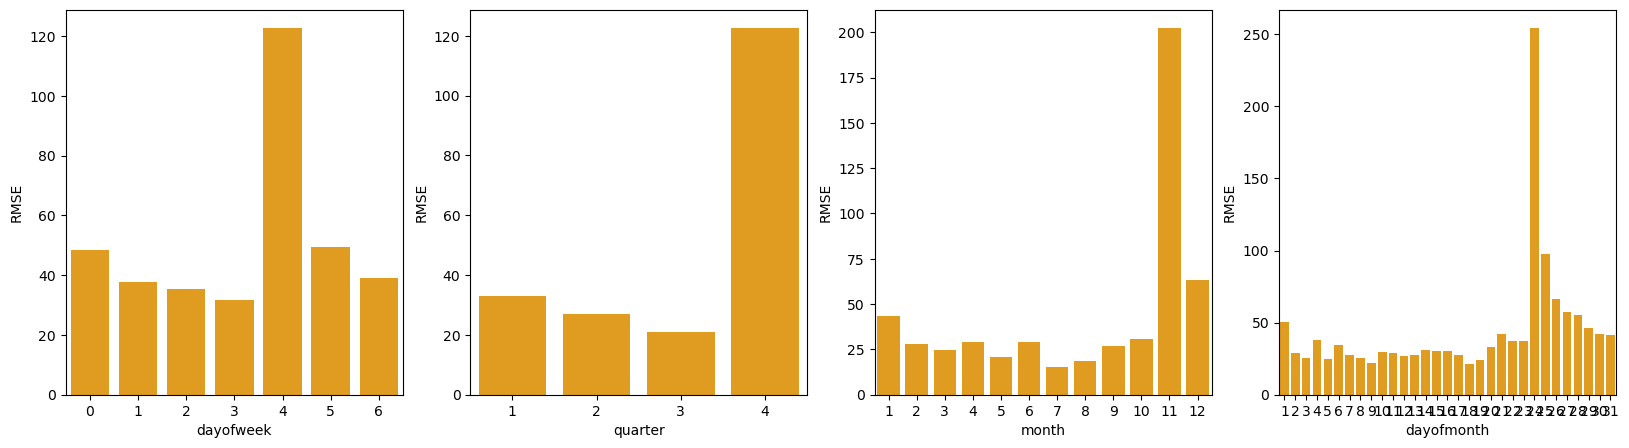

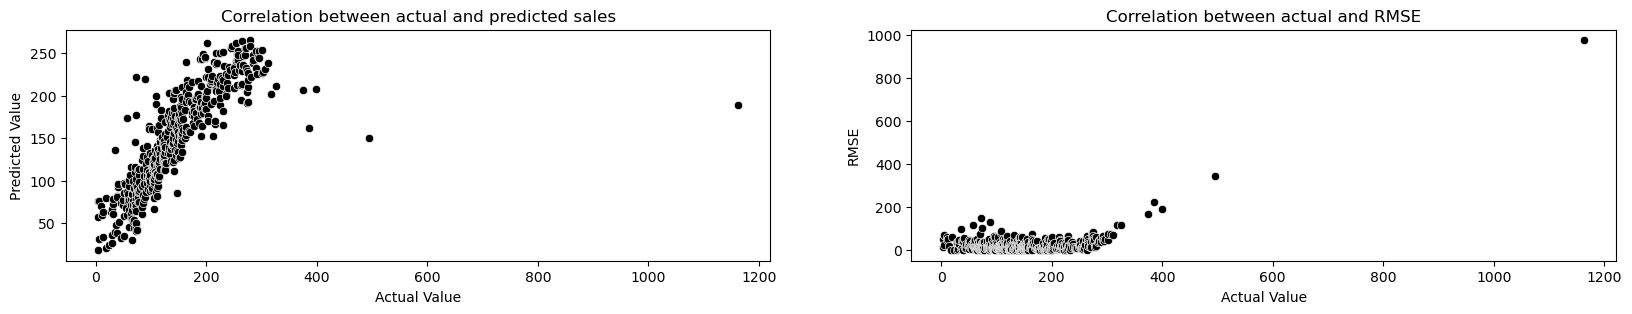

Test dataset evaluation
RMSE: 77.21301880977559


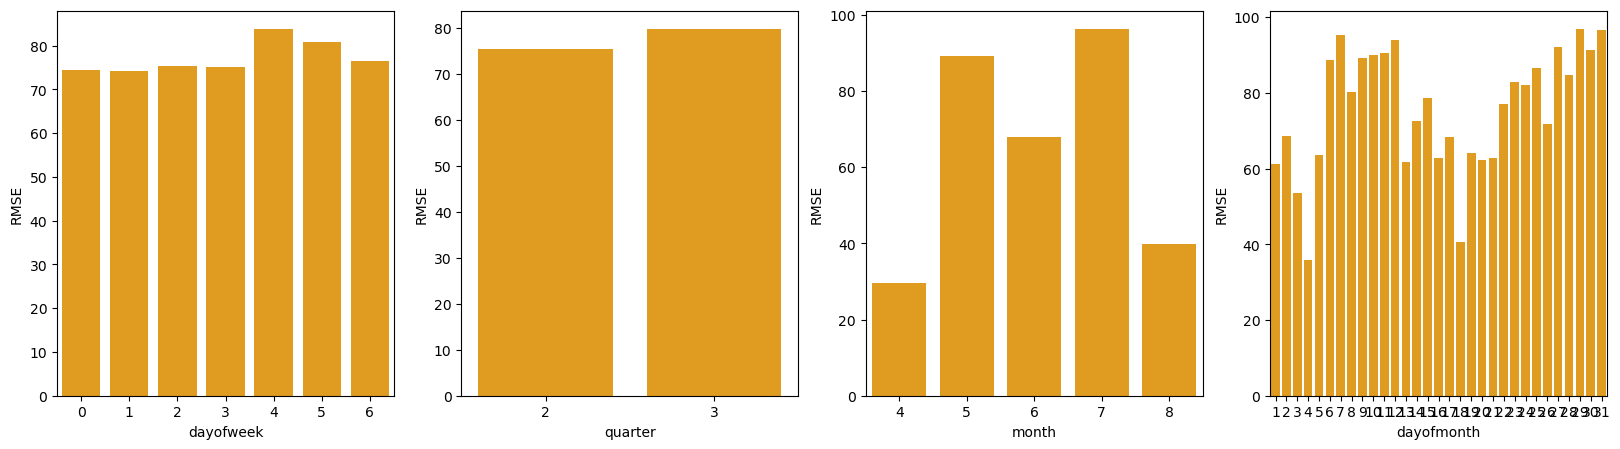

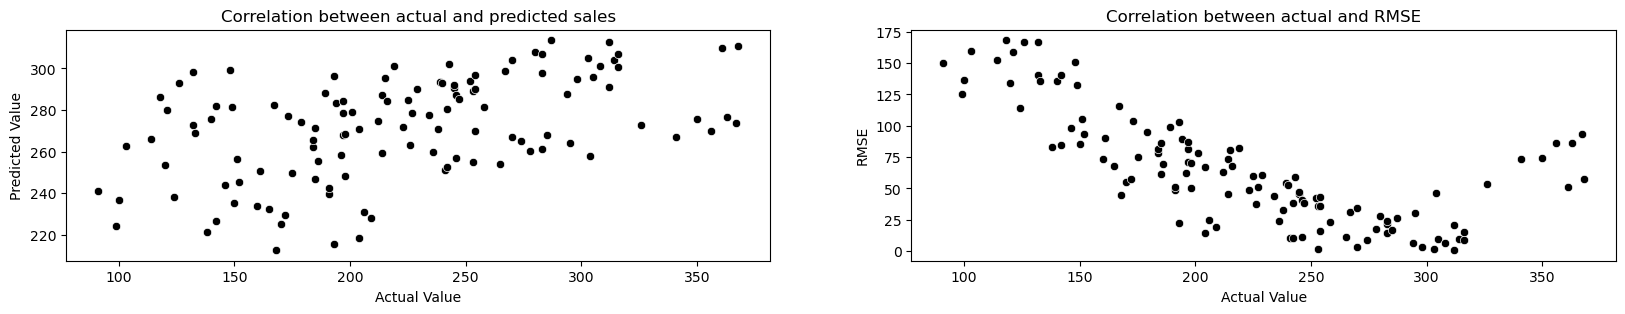

In [24]:
predict_eval(train, test, 'scaling', tuning=True)

07:17:07 - cmdstanpy - INFO - Chain [1] start processing
07:17:07 - cmdstanpy - INFO - Chain [1] done processing
07:17:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
07:17:07 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1, 'seasonality_mode': 'additive'}


07:17:08 - cmdstanpy - INFO - Chain [1] done processing


Train dataset evaluation
RMSE: 37.44527748141899


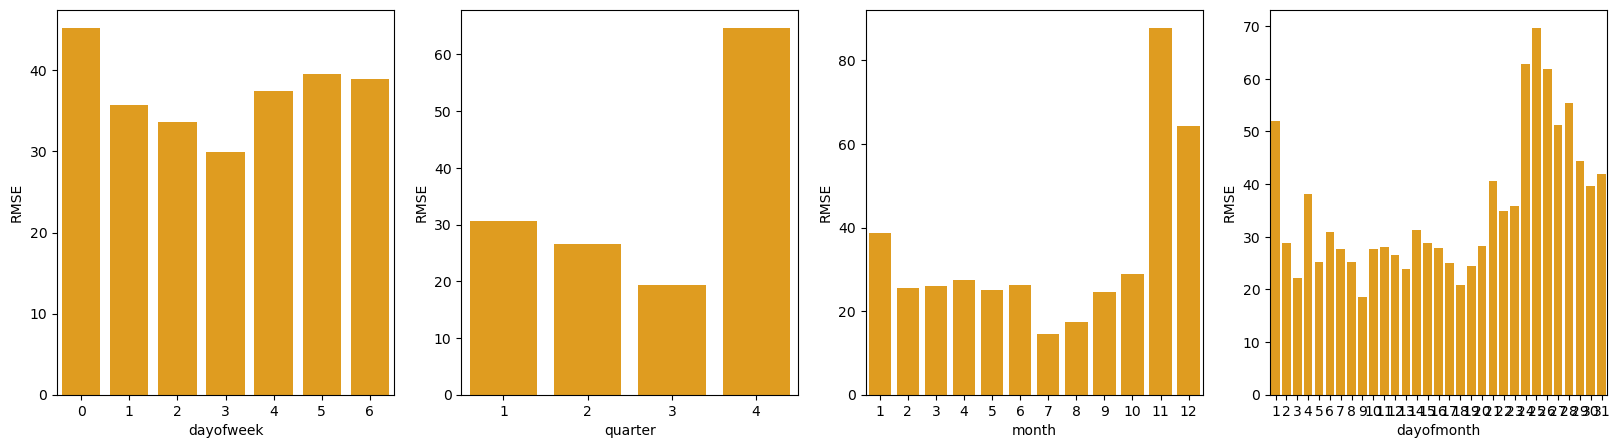

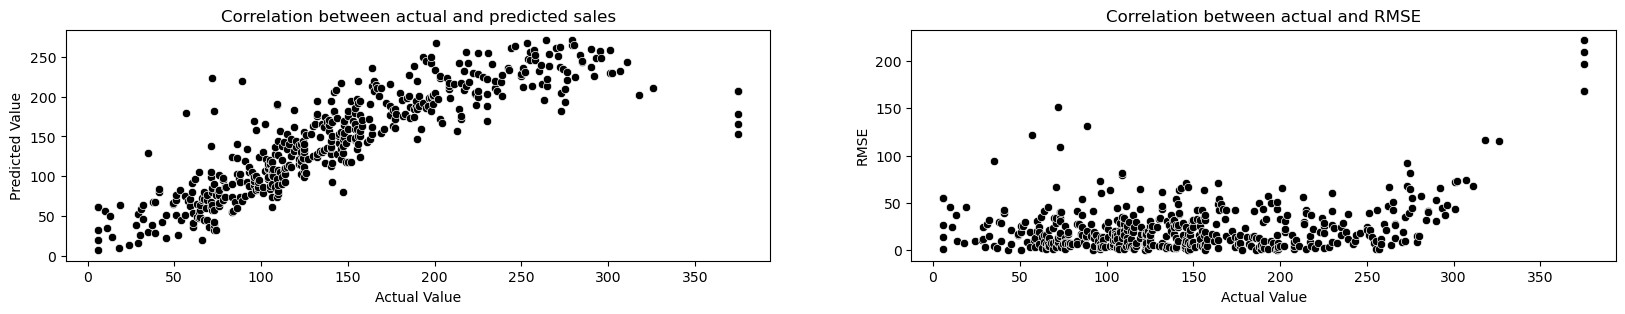

Test dataset evaluation
RMSE: 83.44857965399858


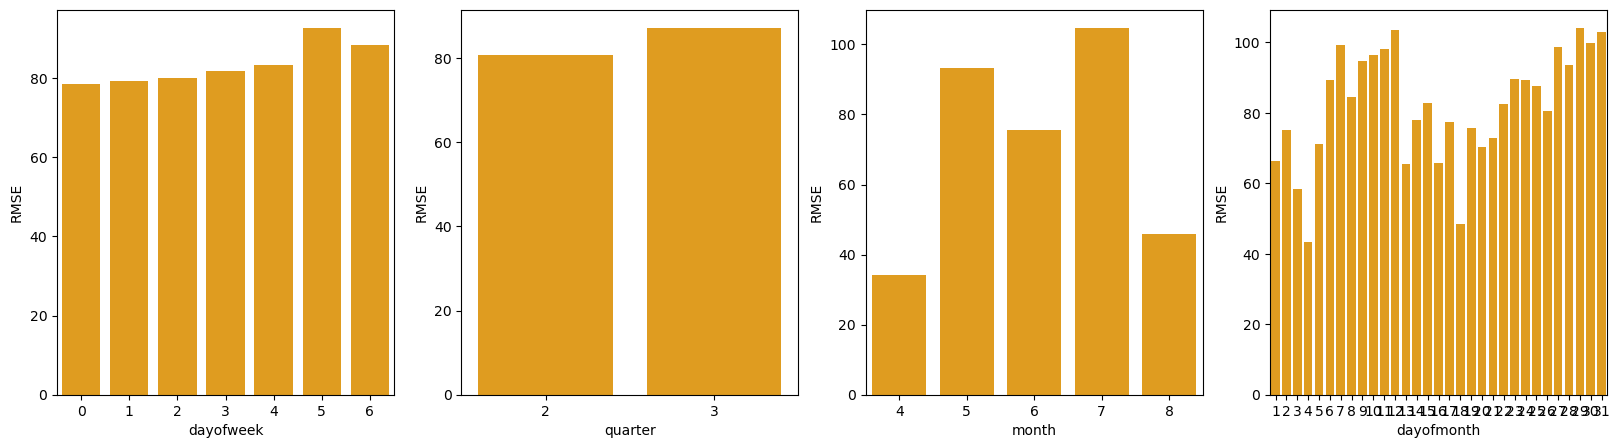

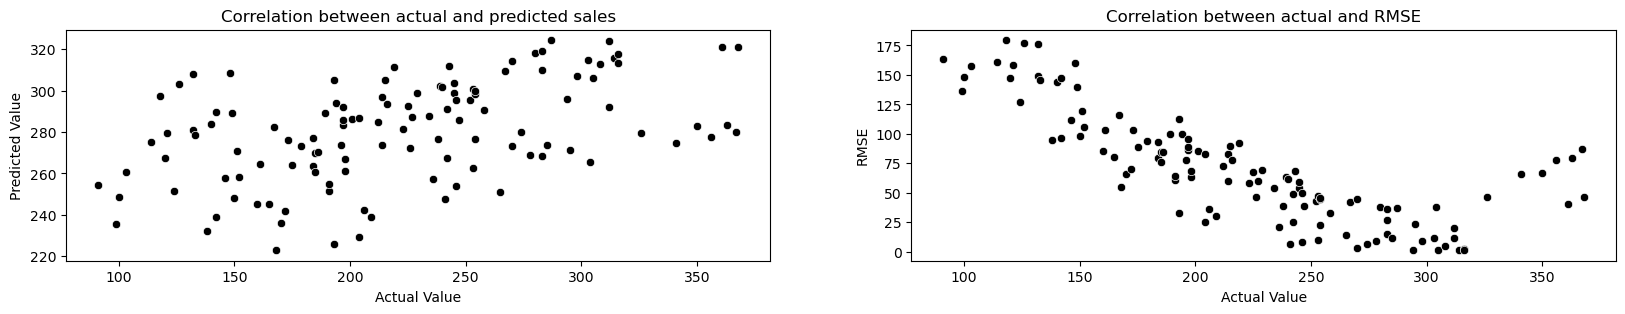

In [25]:
predict_eval(train, test, 'rmv_outliers', tuning=True)